# Setup

## Import libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from pandas.io.json import json_normalize
import json
import os
from sklearn import metrics
import seaborn as sns
%matplotlib inline 

## Set figure properties

In [2]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12

## Read in file

In [135]:
df = pd.read_json('logins.json')

<div class="alert alert-info">
<h1>PART 1: EDA</h1>
</div>

In [136]:
# convert login time to datetime
df['login_time'] = pd.to_datetime(df['login_time'])
df.index = df['login_time'] 

# add count column (1 per row)
df['count'] = 1

# print summary of data
print('Earliest time: {}'.format(df['login_time'].min()))
print('Latest time: {}'.format(df['login_time'].max()))
print('Total observations: {:,}'.format(len(df)))

Earliest time: 1970-01-01 20:12:16
Latest time: 1970-04-13 18:57:38
Total observations: 93,142


## Graph: Logins by 15 Minute Interval

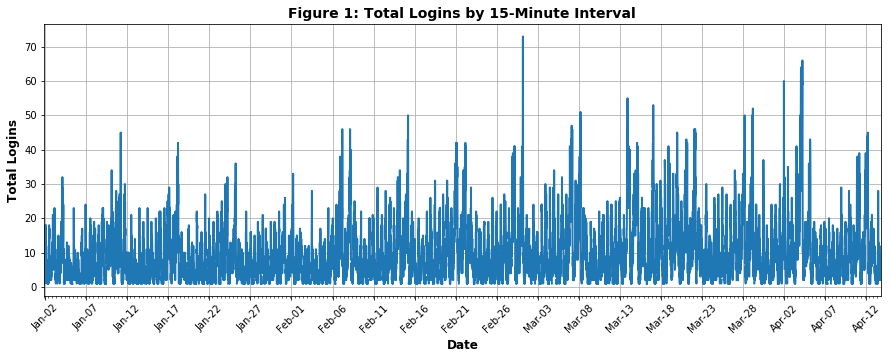

In [137]:
# create dataframe and assign x and y
graph_df = df.resample('15T').sum()
x = graph_df.index
y = graph_df['count']

# setup date formatting
months = mdates.MonthLocator()
days = mdates.DayLocator(interval=5) # ticks every 5 days
hours = mdates.HourLocator(interval=12) # minor ticks every 12 hours
daysFmt = mdates.DateFormatter('%b-%d')

# create graph
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x, y)
ax.grid(True)

# format ticks and labels
ax.xaxis.set_major_formatter(daysFmt)
ax.xaxis.set_major_locator(days)
ax.xaxis.set_minor_locator(hours)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)    

# set x-axis limits
ax.set_xlim([x.min(), x.max()]) 

# create axis labels
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Total Logins', fontweight='bold')
ax.set_title('Figure 1: Total Logins by 15-Minute Interval', fontweight='bold')

# show graph
plt.show()

## Graph: Logins by Day

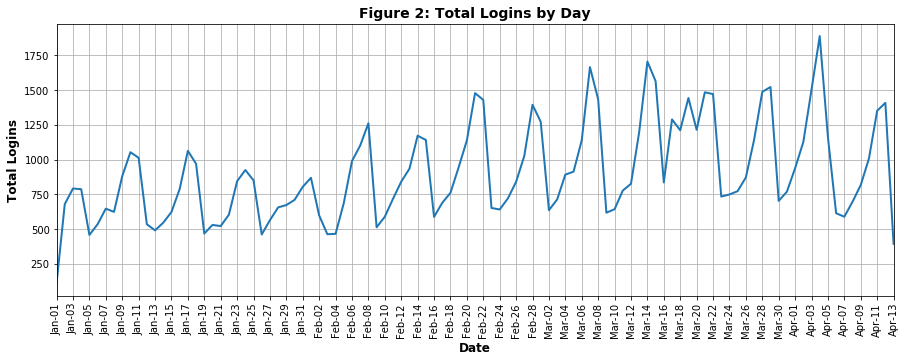

In [138]:
# create dataframe and assign x and y
graph_df = df.resample('1D').sum()
x = graph_df.index
y = graph_df['count']

# setup date formatting
months = mdates.MonthLocator()
days = mdates.DayLocator(interval=2) # ticks every 5 days
daysFmt = mdates.DateFormatter('%b-%d')

# create graph
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x, y)
ax.grid(True)

# format ticks and labels
ax.xaxis.set_major_formatter(daysFmt)
ax.xaxis.set_major_locator(days)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)    

# set x-axis limits
ax.set_xlim([x.min(), x.max()]) 

# create axis labels
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Total Logins', fontweight='bold')
ax.set_title('Figure 2: Total Logins by Day', fontweight='bold')

# show graph
plt.show()

## Graph: Logins by Hour (collapsing across days)

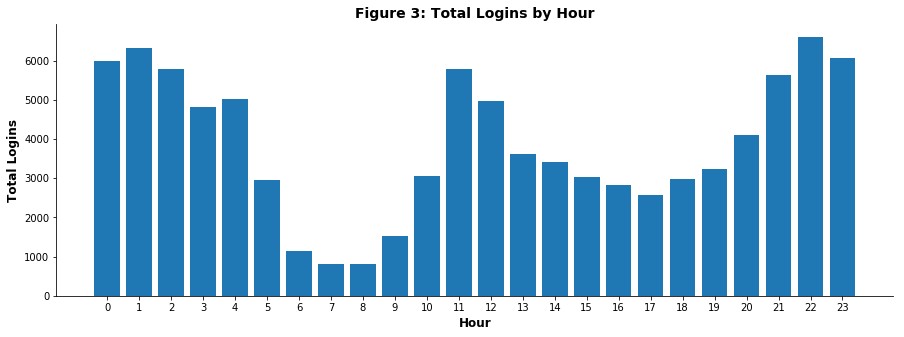

In [140]:
plt.rcParams['figure.figsize'] = 15, 5

# set up dataframe for graph (total logins by hour)
graph_df = df.copy()
graph_df['hour'] = graph_df.index.hour.astype(int)

graph_df = graph_df.groupby('hour').sum()

x = graph_df.index
y = graph_df['count']

# create graph
fig , ax = plt.subplots()
ax.bar(x, y, align='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# format axis labels and ticks
ax.set_xlabel('Hour', fontweight='bold')
ax.set_ylabel('Total Logins', fontweight='bold')
ax.set_title('Figure 3: Total Logins by Hour', fontweight='bold')
ax.set_xticks(x)
plt.show()

## Summary

Figure 2 demonstrates that total logins are increasing over time, though appear to vary significantly by day.  For example, logins are high on January 10th ({{len(df[df.index.date == datetime.date(1970, 1, 10)])}}), drop on January 13th ({{len(df[df.index.date == datetime.date(1970, 1, 13)])}}), and are high again on January 17th ({{len(df[df.index.date == datetime.date(1970, 1, 17)])}}).  As shown in Figure 3, the most popular login times are 9pm-4am and 11am-12pm.  The least popular login times are 6-9am.

<div class="alert alert-info">
<h1>PART 2: EXPERIMENT AND METRICS DESIGN</h1>
</div>

**1.** I would compare the proportion of driver partners that currently serve both cities and the proportion that serve both cities after implementing the toll reimbursement policy.  I could then statistically compare the two groups and determine if the difference is meaningful (i.e., significantly different).  Also, by looking at the proportion of driver partners (rather than the raw number), it ensures that the results aren't impacted by an overall increase or decrease in driver partner numbers.

**2.** To compare the effectiveness of the proposed change, I would determine the proportion of users that serve both cities before and after implementing the toll reimbursement policy.  I would then perform a chi-squared test to determine whether the two proportions are significantly different from one another.  If they are, and the proportion increased after the policy, then I would recommend that the policy be kept in place.  However, if they are *not* significantly different, it would suggest that the policy is not helpful.  (Of course, it's possible that other causes could lead to a non-significant result, such as low sample sizes or other toll-unrelated factors influencing the proportion of driver partners serving both cities.)

<div class="alert alert-info">
<h1>PART 3: PREDICTIVE MODELING</h1>
</div>

## Data cleaning, EDA, and visualizations

### Read in and normalize data

In [100]:
js = json.load((open('ultimate_data_challenge.json')))
js = json_normalize(js)
df = pd.DataFrame(js)

### Determine proportion retained (and add column to dataframe)

In [101]:
df['retained'] = np.where(df['trips_in_first_30_days'] == 0, 0, 1)
print('Proportion of Users Retained: {:.2f}'.format(len(df[df['trips_in_first_30_days'] == 0])/len(df)))

Proportion of Users Retained: 0.31


### Data cleaning: Replacing NaNs
The columns 'avg_rating_by_driver' and 'avg_rating_of_driver' both contain NaNs, so I'm replacing the NaNs with the means for each column

In [96]:
mean_avg_rating_by_driver = df['avg_rating_by_driver'].mean(skipna=True)
df[['avg_rating_by_driver']] = df[['avg_rating_by_driver']].fillna(value=mean_avg_rating_by_driver)

In [97]:
mean_avg_rating_of_driver = df['avg_rating_of_driver'].mean(skipna=True)
df[['avg_rating_of_driver']] = df[['avg_rating_of_driver']].fillna(value=mean_avg_rating_of_driver)

### EDA: Comparing Retained and Lost Users

In [98]:
graph_df = df.groupby('retained').mean()
graph_df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
retained,,,,,,,,
0,6.397854,4.791121,4.625130,1.071320,8.512982,0.000000,0.349513,61.299350
1,5.529568,4.772394,4.591078,1.076295,8.999191,3.291245,0.389338,60.760104


### EDA Summary
As the table above indicates, compared to retained users, non-retained users:
* Traveled shorter distances, on average
* Received slightly higher average ratings
* Gave slightly higher driver ratings
* Took a lower percentage of trips with a surge multiplier greater than 1
* Were less likely to have taken an Ultimate Black in their first 30 days
* Took a larger proportion of trips on weekdays

## Build a predictive model

### Summary of predictive models (see code below)
I tested three different algorithms to accomplish this task: logistic regression, random forest, and support vector classifier.  All three algorithms work well when predicting a binary outcome.  I used AUC as the scoring metric since it tends to work better than accuracy when the classes are imbalanced (as they are here).

The model with the highest AUC was random forest (0.61).  The random forest model also had a comparatively high true negative rate (0.83), which is arguably more important than true positive in this particular case.  That is, it's most important to accurately determine who is likely to *not* be retained in order to intervene, compared to accurately predicting who *will* be retained.  Therefore, I would argue that the random forest model is most useful.

### Recommendations
For both random forest and logistic regression, the most predictive feature/coefficient was average distance.  As the first graph below shows, users who were *not* retained traveled a greater average distance than users who were retained.  This is not necessarily very informative, since the pattern could be attributed to retained users making more (but shorter) trips.

The second most informative coefficient was city.  The second graph below shows that the city with the lowest retention rate is King's Landing (0.65 average retention).  Indeed, an ANOVA indicates that the retention rate in these three cities is significantly different, *F*(2,49997) = 91.99, *p* < .0001.  Therefore, efforts to improve retention should be directed at users in King's Landing.

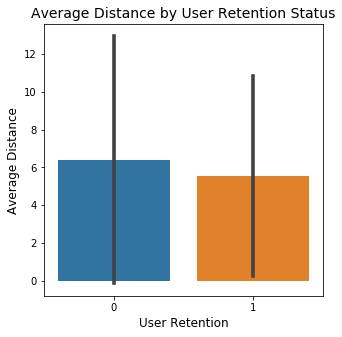

In [123]:
ax = sns.barplot(x='retained', y='avg_dist', data=df_mod, ci='sd')
ax.set(xlabel='User Retention', ylabel='Average Distance', title = 'Average Distance by User Retention Status')

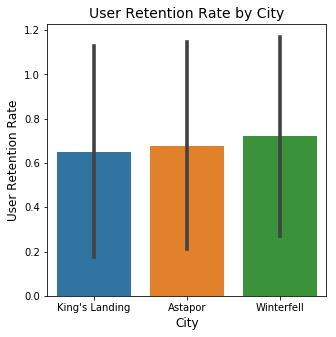

In [122]:
ax = sns.barplot(x='city', y='retained', data=df, ci='sd')
ax.set(xlabel='City', ylabel='User Retention Rate', title='User Retention Rate by City')

**Table for above graph**

In [120]:
df.groupby('city').mean()['retained'].round(2)

city
Astapor           0.68
King's Landing    0.65
Winterfell        0.72
Name: retained, dtype: float64

**ANOVA: User retention by city**

In [134]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import RegressionResults

formula = 'retained ~ city'

sm.stats.anova_lm(m, typ=2)

,sum_sq,df,F,PR(>F)
city,39.057824,2.0,91.99135,1.324318e-40
Residual,10613.900176,49997.0,NaN,NaN


### Data cleaning/prep for modeling

**Replace string columns with numeric columns**

In [58]:
# create dataframe to use for model
df_mod = df.copy()

In [59]:
city_dict = {"Winterfell": 1, "Astapor": 2, "King's Landing": 3}
df_mod['city'] = df_mod['city'].map(city_dict)

In [60]:
df_mod[['phone']] = df[['phone']].fillna(value='None')
phone_dict = {'iPhone': 1, 'Android': 2, 'None': 0}
df_mod['phone'] = df_mod['phone'].map(phone_dict)

In [61]:
df_mod['ultimate_black_user'] = df_mod['ultimate_black_user'].astype(int)

**Remove highly correlated columns (in this case, removing 'surge_pct' and keeping 'avg_surge')**

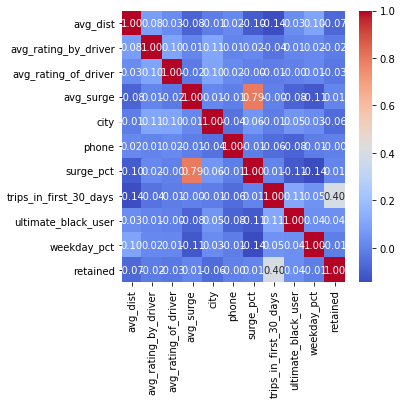

In [62]:
corr = df_mod.corr(method='pearson')

g = sns.heatmap(corr, 
                 xticklabels=corr.columns,
                 yticklabels=corr.columns,
                 cmap='coolwarm',
                 annot=True,
                fmt='.2f')
plt.rcParams['figure.figsize']=(20,20)
plt.show()

### Modeling functions

In [16]:
""" Perform cross-validation """

def cv_optimize(clf, dict_params, Xtrain, ytrain, scorer, n_folds):
    
    from sklearn.model_selection import GridSearchCV

    gs = GridSearchCV(clf,
                      param_grid = dict_params,
                      cv = n_folds,
                      scoring = scorer) 
    
    gs.fit(Xtrain, ytrain)
    
    print('Cross validation completed.')
    print('Best parameters: ' + str(gs.best_params_))
    print('Best score: {:.2f}'.format(gs.best_score_))
    
    return gs.best_estimator_, gs.best_params_

In [49]:
""" Evaluate model """

def model_eval(clf, Xtrain, ytrain, Xtest, ytest):
    
    # get predictions for y
    ypred_test = clf.predict(Xtest)
    ypred_train = clf.predict(Xtrain)
    try:
        ypred_proba = clf.predict_proba(Xtest)
        auc = metrics.roc_auc_score(ytest, ypred_proba[:,1])
    except:
        ypred = clf.predict(Xtest)
        auc = 0
    
    # create confusion matrix
    cnf_matrix = metrics.confusion_matrix(ytest, ypred_test)
    np.set_printoptions(precision=2)

    # print model performance summary
    print('Training accuracy: {:.2f}%'.format(100*metrics.accuracy_score(ypred_train, ytrain)),
          '\nTest accuracy: {:.2f}%'.format(100*metrics.accuracy_score(ypred_test, ytest)),
          '\nPrecision: {:.2f}'.format(metrics.precision_score(ytest, ypred_test)),
          '\nRecall: {:.2f}'.format(metrics.recall_score(ytest, ypred_test)),
          '\nF1: {:.2f}'.format(metrics.f1_score(ytest, ypred_test)),
          '\nAUC: {:.2f}'.format(auc),
          '\nTrue Positive Rate: {:.2f}'.format(float(cnf_matrix[0][0])/np.sum(cnf_matrix[0])),
          '\nTrue Negative Rate: {:.2f}'.format(float(cnf_matrix[1][1])/np.sum(cnf_matrix[1]))
         )

    # display confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, np.unique(ytest))
    plt.rcParams['figure.figsize']=(5,5)
    plt.show()

In [79]:
""" Plot confusion matrix """

def plot_confusion_matrix(cm, classes):
    
    import itertools
    
    normalize = False
    
    plt.rcParams['figure.figsize'] = 5, 5
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
""" Create and return dataframe with feature/coefficient importances """

def show_feature_import(clf, features, Xtest, y_col):
    
    if hasattr(clf, 'coef_'):
        coefs = np.std(Xtest, 0)*clf.coef_[0,0:]
    else:
        print('Cannot show feature importances.')
        return

    df_graph = pd.DataFrame({'Feature': features,
                             'Coefficient': coefs,
                             'Coeff_AV': abs(coefs)})

    df_graph.sort_values(by = 'Coeff_AV', ascending = False, inplace=True)
    
    return df_graph

### Modeling setup

**Assign X and y**

In [19]:
y = df_mod['retained']

exclude = ['last_trip_date', 'signup_date', 'retained', 'trips_in_first_30_days', 'surge_pct']
X_cols = [x for x in df_mod.columns if (x not in exclude)]
X = df_mod[X_cols]

**Create training and test sets**

In [20]:
from sklearn.cross_validation import train_test_split

_, itest = train_test_split(range(df_mod.shape[0]), train_size = 0.7)
mask = np.zeros(df_mod.shape[0], dtype=np.bool)
mask[itest] = True

test = df_mod[mask]
train = df_mod[~mask]
Xtest = test[X_cols]
ytest = test['retained']
Xtrain = train[X_cols]
ytrain = train['retained']

/Users/Rachel/.pyenv/versions/py36_env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Mask already existed, opened mask_test.txt


**Make sure proportion of retained users is approximately equal in training and test sets**

In [21]:
prop_ret = sum(train['retained'])/len(train)
print('Percent of retained (1) in training set: {:.2f}%'.format(prop_ret*100))

prop_ret = sum(test['retained'])/len(test)
print('Percent of retained (1) in test set: {:.2f}%'.format(prop_ret*100))

Percent of retained (1) in training set: 69.21%
Percent of retained (1) in test set: 69.25%


### Model 1: Logistic regression

Cross validation completed.
Best parameters: {'C': 0.001, 'class_weight': {0: 0.7, 1: 0.3}, 'fit_intercept': False}
Best score: 0.50
Training accuracy: 52.48% 
Test accuracy: 52.59% 
Precision: 0.74 
Recall: 0.49 
F1: 0.59 
AUC: 0.57 
True Positive Rate: 0.61 
True Negative Rate: 0.49


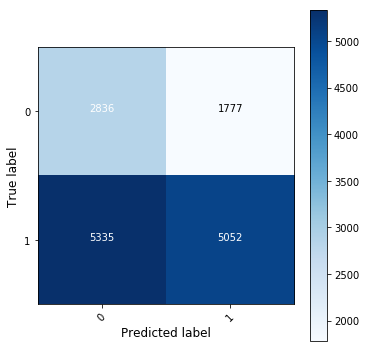

,Coeff_AV,Coefficient,Feature
avg_dist,0.140771,-0.140771,avg_dist
city,0.081107,-0.081107,city
ultimate_black_user,0.046904,0.046904,ultimate_black_user
avg_rating_by_driver,0.019971,0.019971,avg_rating_by_driver
avg_surge,0.006239,0.006239,avg_surge
phone,0.005738,0.005738,phone
weekday_pct,0.004464,0.004464,weekday_pct
avg_rating_of_driver,0.002132,-0.002132,avg_rating_of_driver


In [85]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

dict_params = {'C': [.001, .001, .01, .1, 1],
               'class_weight': [{0:.7, 1:.3}], # to account for greater number of retained
               'fit_intercept': [False]}

scorer = metrics.make_scorer(metrics.auc, reorder=True)
clf_LR, best_params_LR = cv_optimize(clf, dict_params, Xtrain, ytrain, scorer, n_folds=5)
model_eval(clf_LR, Xtrain, ytrain, Xtest, ytest)

# print feature importances
coef_df = show_feature_import(clf_LR, X_cols, Xtest, 'retained')
coef_df

### Model 2: Random forest

Cross validation completed.
Best parameters: {'min_samples_split': 10, 'n_estimators': 5}
Best score: 0.50
Training accuracy: 82.47% 
Test accuracy: 66.07% 
Precision: 0.72 
Recall: 0.83 
F1: 0.77 
AUC: 0.61 
True Positive Rate: 0.29 
True Negative Rate: 0.83


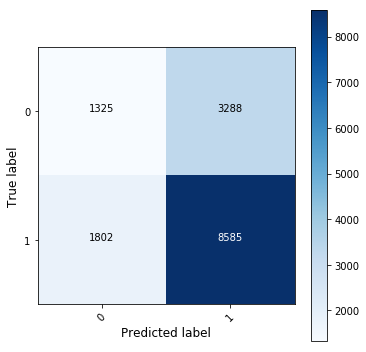

Cannot show feature importances.


In [88]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

dict_params = {'n_estimators': list(np.arange(5, 20, 5)),
               'min_samples_split': list(np.arange(10, 50, 10))}

scorer = metrics.make_scorer(metrics.auc, reorder=True)
clf_RF, best_params_RF = cv_optimize(clf, dict_params, Xtrain, ytrain, scorer, n_folds=5)

model_eval(clf_RF, Xtrain, ytrain, Xtest, ytest)

# print feature importances
coef_df = show_feature_import(clf_RF, X_cols, Xtest, 'retained')
coef_df

### Model 3: Support vector classifier

Training accuracy: 75.57% 
Test accuracy: 68.29% 
Precision: 0.71 
Recall: 0.92 
F1: 0.80 
AUC: 0.58 
True Positive Rate: 0.15 
True Negative Rate: 0.92


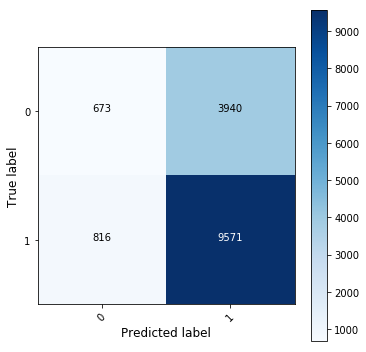

In [26]:
from sklearn.svm import SVC

clf = SVC()

dict_params = {'C': [10**0.1, 10**0, 10**1],
               'gamma': [10**0, 10**0.1, 10**1],
               'probability': [True]}

scorer = metrics.make_scorer(metrics.auc, reorder=True)
clf_SV, best_params_SV = cv_optimize(clf, dict_params, Xtrain, ytrain, scorer, n_folds=5)

model_eval(clf_SV, Xtrain, ytrain, Xtest, ytest)